# Decison Tree Classification model on Amazon Fine foods reviews dataset.


 * Our objective here is to build a <b> 'Decision Trees' classifier to estimate the polarity of a review as Positive/Negative</b> based on the words used in the review.

 * We are given a 500K datset of reviews from Amazon customers regarding the various food products.

 * We will be using 5 types of Vectorizations to convert text reviews into vectors and we will conclude towards the best Vectorizer based on several performance metrics.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import graphviz
import wordcloud
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from wordcloud import WordCloud
#from tqdm import tqdm

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [5]:
con=sqlite3.connect('G:\ML\Data_Sets\Amazon\Cleaned_AmazonDB.sqlite')

In [6]:
data=pd.read_sql_query('''Select * from Reviews''',con)
data.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak watch realli rosi movi incorp...
2,2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [10]:
data.shape

(364171, 13)

In [114]:
data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

Since the data here is imbalanced we will use the <b>class_weight</b> parameter in our DT model as <b>'Balanced'</b>.

## Time based sorting of data:

In [7]:
sorted_data=data.sort_values('Time',axis=0,ascending=True)

In [11]:
sorted_data.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year child sister ...
424,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur star michael keaton...
423,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## Splitting of Test and Train data

In [8]:
train_length=round(0.7*len(data))
print(train_length)
test_length=round(0.3*len(data))
print(test_length)
print((train_length+test_length)==len(data))

254920
109251
True


In [9]:
train=sorted_data.head(train_length)
test=sorted_data.tail(test_length)

## Grid Search CV

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [11]:
def grid_s(x,list_depth=range(1,50,2)):
    '''
    Program to return optimal depth of the Decision tree.
    '''
    ts=TimeSeriesSplit(n_splits=10)
    par=[{'max_depth':list_depth}]
    dt=DecisionTreeClassifier(random_state=3,class_weight='balanced')
    grid=GridSearchCV(dt,par,cv=ts.split(x),scoring='accuracy',verbose=2)
    return grid

## Randomized Search CV

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [40]:
def random_s(x):
    '''
    To tune Hyper paramater using Randomized Search CV
    '''
    ts=TimeSeriesSplit(n_splits=10)
    par={'max_depth': uniform.rvs(loc=0,scale=10**3,size=5)}    
    dt=DecisionTreeClassifier(random_state=3,class_weight='balanced')
    rand=RandomizedSearchCV(dt,par,cv=ts.split(x),scoring='accuracy',verbose=1,n_iter=5)
    return rand

## CV Plotter:

In [15]:
def plotter(x):
    '''
    To plot CV error with different values of depth.
    '''
    tmp=pd.DataFrame(x.cv_results_)
    plt.figure(figsize=(12,7))
    plt.plot(tmp['param_max_depth'],1-tmp['mean_test_score'])
    plt.xlabel('Depth --> ')
    plt.ylabel('CV Error-->')
    plt.title('Variation in CV error of the tree With respect to Depth')
    plt.grid()
    plt.show()
    

## Feature importance:

In [16]:
def feat_importance(dt,vectorizer):
    '''
    To return top 20 features from a model
    '''
    imp=dt.feature_importances_
    top=imp.argsort()[::-1]
    print('Top 20 important features are : \n')
    top_20=''
    for i in range(20):
        #print( np.take(vectorizer.get_feature_names(),top[i]))
        tmp=np.take(vectorizer.get_feature_names(),top[i])
        top_20=top_20+tmp+' '
    #print(top_20)    
    wc=WordCloud(width=800,height=700,background_color='white').generate(top_20)
    plt.figure(figsize=(6,6))
    plt.imshow(wc)
    plt.axis('off')

## Visualizing Decision tree using Graphviz:

In [10]:
def tree_viz(x_train,y_train,vect):
    '''
    To visualize the tree using graphviz for a depth of 5
    '''
    d_tree=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')
    d_tree.fit(x_train,y_train)
    DT=tree.export_graphviz(d_tree,out_file=None,feature_names=vect.get_feature_names(),class_names=['positive','negative'],filled=True)
    x=graphviz.Source(DT)
    return x

## Confusion Matrix & Performance Analyser:

In [11]:
def CM(x,y):
    '''
    Function to plot confusion matrix
    '''
    CM_Matrix=confusion_matrix(x,y)
    tn,fn,fp,tp=CM_Matrix.ravel()
    print('\n******************************************************************************* \n')
    print(f' Accuracy is {accuracy_score(x,y)}')
    print('\n******************************************************************************* \n')
    
    print(f" TNR value is {tn/(tn+fn)}")
    print(f" FNR value is {fn/(tn+fn)}")
    print(f" FPR value is {fp/(tp+fp)}")
    print(f" TPR value is {tp/(tp+fp)}")
    
    print('\n******************************************************************************* \n')
    print(' Confusion Matrix is :')
    print(CM_Matrix)
    
    print('\n******************************************************************************* \n')
    precision= tp/(tp+fp)
    print(f' Precision is {precision}')
    recall=tp/(tp+fn)
    print(f' Recall value is {recall}')
    f1=2*((precision*recall)/(precision+recall))
    print(f' F1 Score is {f1}')
    
    print('\n******************************************************************************* \n')
    print('Heat Map of the Confusion matrix is')
    tmp=pd.DataFrame(CM_Matrix)
    ann=np.array([['True Negative = '+str(tn),'False negative = '+str(fn)],['False Positive = '+str(fp),'True Positive = '+str(tp)]])
    sns.heatmap(tmp,annot=ann,fmt='')
    plt.title('Confusion Matrix : ')
    
    print('\n******************************************************************************* \n')
    
    

# 1.) Bag Of Words Vectorization:

In [14]:
BOW=CountVectorizer(dtype='float')
BOW.fit(train['New'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='float', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=1, ngram_range=(1, 1),
        preprocessor=None, stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [15]:
BOW_train= BOW.transform(train['New'])
BOW_test=BOW.transform(test['New'])

In [19]:
BOW_train.shape

(254920, 55207)

In [16]:
scaler=StandardScaler(with_mean=False)
std_BOW_train=scaler.fit_transform(BOW_train)
std_BOW_test=scaler.transform(BOW_test)

### Cross Validation :

In [42]:
BOW_grid=grid_s(std_BOW_train[0:100000])

In [43]:
BOW_grid.fit(std_BOW_train[0:100000],train['Score'][0:100000])

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.3s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ...................................... max_depth=1, total=   0.6s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.9s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   1.6s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   1.9s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   2.8s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   3.5s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   4.1s
[CV] max_depth=1 .....................................................
[CV] .

[CV] ..................................... max_depth=11, total=  14.2s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   1.8s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   2.9s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   4.0s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   5.8s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   8.4s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=  12.6s
[CV] max_depth=13 ....................................................
[CV] .

[CV] ..................................... max_depth=23, total=  35.5s
[CV] max_depth=23 ....................................................
[CV] ..................................... max_depth=23, total=  39.0s
[CV] max_depth=23 ....................................................
[CV] ..................................... max_depth=23, total=  41.9s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   2.6s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   5.4s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   9.1s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=  14.3s
[CV] max_depth=25 ....................................................
[CV] .

[CV] ..................................... max_depth=35, total=  28.4s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=  37.2s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=  46.0s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=  54.3s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total= 1.1min
[CV] max_depth=37 ....................................................
[CV] ..................................... max_depth=37, total=   3.0s
[CV] max_depth=37 ....................................................
[CV] ..................................... max_depth=37, total=   6.4s
[CV] max_depth=37 ....................................................
[CV] .

[CV] ..................................... max_depth=47, total=  19.4s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=  28.6s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=  35.4s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=  45.6s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=  54.8s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total= 1.1min
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total= 1.3min
[CV] max_depth=49 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 90.4min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001423DE9C8E0>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': range(1, 50, 2)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [44]:
BOW_grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=49, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [45]:
BOW_grid.best_score_

0.8163586358635864

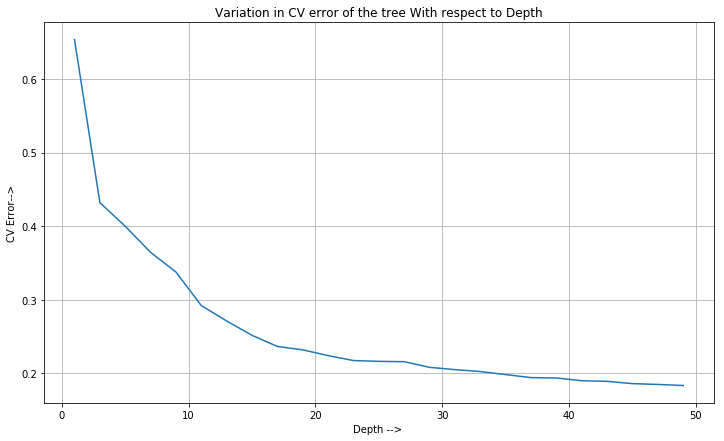

In [64]:
plotter(BOW_grid)

As the error seems to be decreasing continously and no inflection point are observed from the graph. Hence taking grid search for wide range of points and repeating the cross validation.

In [55]:
g2=grid_s(std_BOW_train[0:100000],[10,100,150,200,250])
g2.fit(std_BOW_train[0:100000],train['Score'][0:100000])

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   1.2s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ..................................... max_depth=10, total=   2.2s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   3.1s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   4.8s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   5.6s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   7.8s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   9.5s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=  12.3s
[CV] max_depth=10 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 43.8min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001423AC1AF68>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [10, 100, 150, 200, 250]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [56]:
print(g2.best_score_)
g2.best_estimator_

0.8357865786578658


DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=250, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

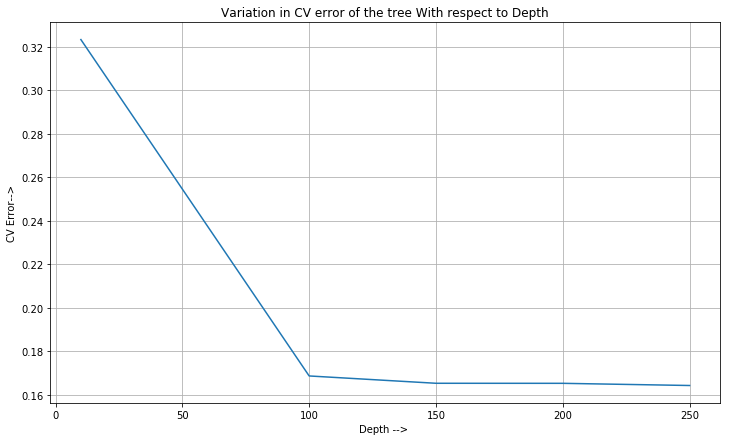

In [65]:
plotter(g2)

As expected we got an elbow point at <b> depth 100 </b> , beyond which the error is decreasing slowly.

In [68]:
g3=grid_s(std_BOW_train[0:100000],[1000,10000,500000,100000])
g3.fit(std_BOW_train[0:100000],train['Score'][0:100000])

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] max_depth=1000 ..................................................
[CV] ................................... max_depth=1000, total=   5.0s
[CV] max_depth=1000 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] ................................... max_depth=1000, total=  11.2s
[CV] max_depth=1000 ..................................................
[CV] ................................... max_depth=1000, total=  25.0s
[CV] max_depth=1000 ..................................................
[CV] ................................... max_depth=1000, total=  39.1s
[CV] max_depth=1000 ..................................................
[CV] ................................... max_depth=1000, total=  51.9s
[CV] max_depth=1000 ..................................................
[CV] ................................... max_depth=1000, total= 1.2min
[CV] max_depth=1000 ..................................................
[CV] ................................... max_depth=1000, total= 1.6min
[CV] max_depth=1000 ..................................................
[CV] ................................... max_depth=1000, total= 2.2min
[CV] max_depth=1000 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 49.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001423D2375C8>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [1000, 10000, 500000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

0.8349064906490649
DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=1000, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')


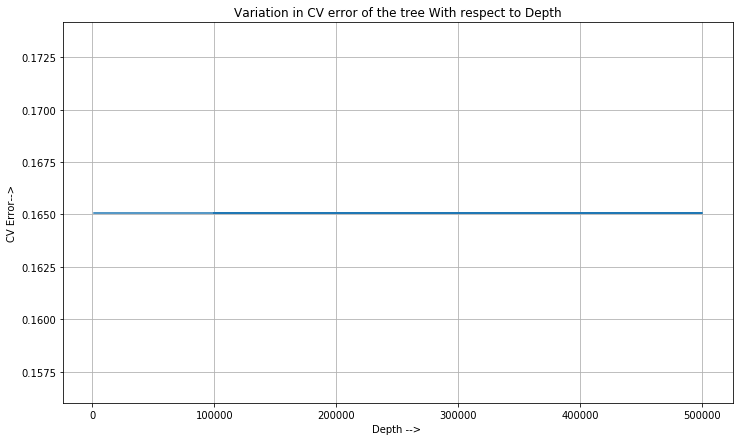

In [105]:
print(g3.best_score_)
print(g3.best_estimator_)
plotter(g3)

Since the dimensions of data are too high, We got the error saturated only after a huge depth(around 1000s). 

In [110]:
#Random Search
BOW_rand=random_s(std_BOW_train[0:100000])

In [111]:
BOW_rand.fit(std_BOW_train[0:100000],train['Score'][0:100000])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] max_depth=3140.4840903579134 ....................................
[CV] ..................... max_depth=3140.4840903579134, total=   5.0s
[CV] max_depth=3140.4840903579134 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] ..................... max_depth=3140.4840903579134, total=  12.1s
[CV] max_depth=3140.4840903579134 ....................................
[CV] ..................... max_depth=3140.4840903579134, total=  25.7s
[CV] max_depth=3140.4840903579134 ....................................
[CV] ..................... max_depth=3140.4840903579134, total=  38.0s
[CV] max_depth=3140.4840903579134 ....................................
[CV] ..................... max_depth=3140.4840903579134, total=  49.4s
[CV] max_depth=3140.4840903579134 ....................................
[CV] ..................... max_depth=3140.4840903579134, total= 1.0min
[CV] max_depth=3140.4840903579134 ....................................
[CV] ..................... max_depth=3140.4840903579134, total= 1.2min
[CV] max_depth=3140.4840903579134 ....................................
[CV] ..................... max_depth=3140.4840903579134, total= 1.6min
[CV] max_depth=3140.4840903579134 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.5min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001421C488678>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3140.4840903579134]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [34]:
BOW_rand.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=14.73341444167473, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=3, splitter='best')

In [108]:
BOW_rand.best_score_

0.6355555555555555

### Implementation:

#### The optimal depth chosen from CV plot is 100.

In [22]:
dt=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [23]:
dt.fit(std_BOW_train,train['Score'])

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [23]:
pred=dt.predict(std_BOW_test)

In [24]:
acc=accuracy_score(pred,test['Score'])
print(acc*100)

81.88300335923698


## Performace of Decision trees model with BOW_unigram:


******************************************************************************* 

 Accuracy is 0.8188300335923698

******************************************************************************* 

 TNR value is 0.6035847177820869
 FNR value is 0.3964152822179131
 FPR value is 0.13562160363757347
 TPR value is 0.8643783963624265

******************************************************************************* 

 Confusion Matrix is :
[[11517  7564]
 [12229 77941]]

******************************************************************************* 

 Precision is 0.8643783963624265
 Recall value is 0.9115373369978363
 F1 Score is 0.8873317205066172

******************************************************************************* 

Heat Map of the Confusion matrix is

******************************************************************************* 



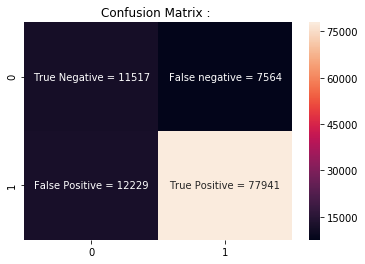

In [25]:
CM(test['Score'],pred)

### Saving the tree to a PDF file.

In [24]:
tmp=tree_viz(std_BOW_train,train['Score'],BOW)
tmp.render(filename='G:\ML\Exercises\ex 7\Graphviz\BOW1')

'G:\\ML\\Exercises\\ex 7\\Graphviz\\BOW1.pdf'

* It would be too complicated to Visualize the tree with suge a huge depth of 100, I took a depth of 5 and created dot file using Graphviz.


* Since visualizing the trees in the ipynb makes it too slow to scroll. I exported them to a pdf file in my local machine.


* For a sample visualization of Decision tree, I added DT for one of the vectorization at the end of this notebook.

## Feature Importance:

Top 20 important features are : 



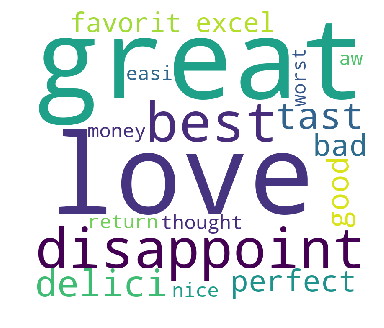

In [86]:
feat_importance(dt,BOW)

# 2.) BOW - Bi-gram Vectorization:

In [13]:
BOW1=CountVectorizer(ngram_range=(1,2),dtype='float')
BOW1.fit(train['New'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='float', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=1, ngram_range=(1, 2),
        preprocessor=None, stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [14]:
BOW1_train= BOW1.transform(train['New'])
BOW1_test=BOW1.transform(test['New'])

In [19]:
BOW1_train.shape

(254920, 2184164)

In [15]:
scaler=StandardScaler(with_mean=False)
std_BOW1_train=scaler.fit_transform(BOW1_train)
std_BOW1_test=scaler.transform(BOW1_test)

### Cross validation :

In [19]:
BOW1_grid=grid_s(std_BOW1_train[:10000])

In [20]:
BOW1_grid.fit(std_BOW1_train[0:10000],train['Score'][:10000])

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   1.8s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ...................................... max_depth=1, total=   2.0s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   2.3s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   2.5s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   3.0s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   3.4s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   3.9s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   4.6s
[CV] max_depth=1 .....................................................
[CV] .

[CV] ..................................... max_depth=11, total=  23.8s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   5.4s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   7.8s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=  15.7s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=  19.8s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=  24.2s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=  27.6s
[CV] max_depth=13 ....................................................
[CV] .

[CV] ..................................... max_depth=23, total=  44.9s
[CV] max_depth=23 ....................................................
[CV] ..................................... max_depth=23, total=  51.2s
[CV] max_depth=23 ....................................................
[CV] ..................................... max_depth=23, total=  58.3s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   9.6s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=  12.9s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=  22.8s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=  27.9s
[CV] max_depth=25 ....................................................
[CV] .

[CV] ..................................... max_depth=35, total=  56.1s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total= 1.2min
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total= 1.3min
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total= 1.4min
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total= 1.4min
[CV] max_depth=37 ....................................................
[CV] ..................................... max_depth=37, total=  11.8s
[CV] max_depth=37 ....................................................
[CV] ..................................... max_depth=37, total=  16.7s
[CV] max_depth=37 ....................................................
[CV] .

[CV] ..................................... max_depth=47, total=  30.2s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=  36.6s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=  47.9s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=  55.3s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total= 1.0min
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total= 1.2min
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total= 1.2min
[CV] max_depth=49 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 126.9min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000024869144A40>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': range(1, 50, 2)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [21]:
BOW1_grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=49, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [22]:
BOW1_grid.best_score_

0.7962596259625963

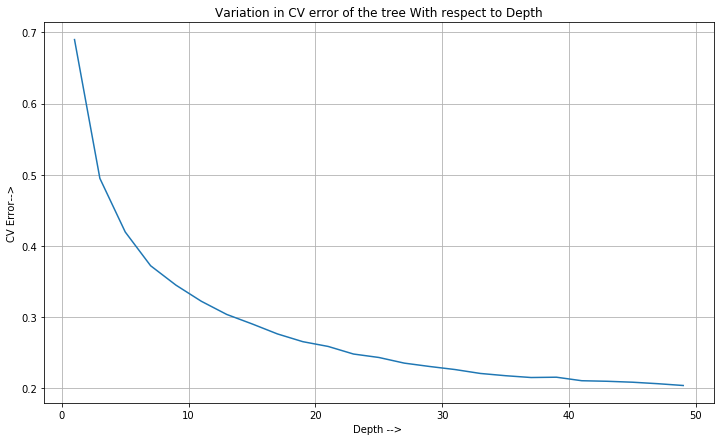

In [23]:
plotter(BOW1_grid)

In [32]:
BOW1_grid=grid_s(std_BOW1_train[:10000],[10,100,150,200,250,300])

In [33]:
BOW1_grid.fit(std_BOW1_train[0:10000],train['Score'][:10000])

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   7.5s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] ..................................... max_depth=10, total=  10.8s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=  15.5s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=  22.4s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=  24.4s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=  35.7s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=  29.2s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=  30.9s
[CV] max_depth=10 ....................................................
[CV] .

[CV] .................................... max_depth=300, total= 2.4min


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 71.7min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001784B2D8BF8>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [10, 100, 150, 200, 250, 300]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [34]:
BOW1_grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=200, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [35]:
BOW1_grid.best_score_

0.8127612761276127

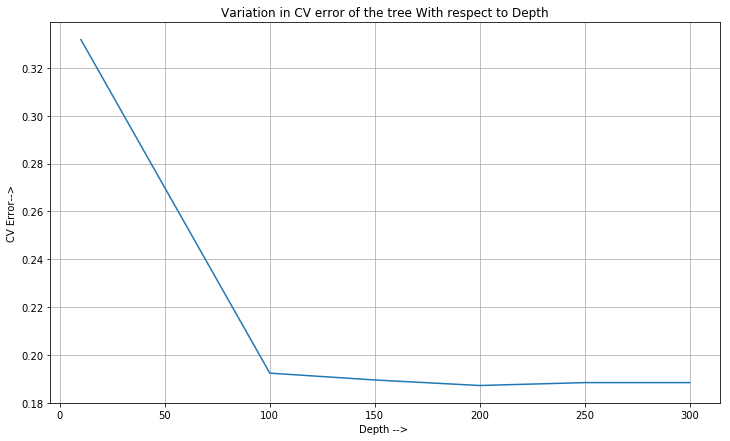

In [36]:
plotter(BOW1_grid)

The inflection point is obtained at the <b>depth of 100.

In [21]:
#Random Search
BOW_rand=random_s(std_BOW1_train[:10000])

In [22]:
BOW_rand.fit(std_BOW1_train[:10000],train['Score'][:10000])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] max_depth=2953.0519475390406 ....................................
[CV] ..................... max_depth=2953.0519475390406, total=  21.7s
[CV] max_depth=2953.0519475390406 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s


[CV] ..................... max_depth=2953.0519475390406, total=  45.3s
[CV] max_depth=2953.0519475390406 ....................................
[CV] ..................... max_depth=2953.0519475390406, total= 1.1min
[CV] max_depth=2953.0519475390406 ....................................
[CV] ..................... max_depth=2953.0519475390406, total= 1.1min
[CV] max_depth=2953.0519475390406 ....................................
[CV] ..................... max_depth=2953.0519475390406, total= 1.1min
[CV] max_depth=2953.0519475390406 ....................................
[CV] ..................... max_depth=2953.0519475390406, total= 1.5min
[CV] max_depth=2953.0519475390406 ....................................
[CV] ..................... max_depth=2953.0519475390406, total= 2.1min
[CV] max_depth=2953.0519475390406 ....................................
[CV] ..................... max_depth=2953.0519475390406, total= 1.9min
[CV] max_depth=2953.0519475390406 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 15.7min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000184802AC938>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2953.0519475390406]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [23]:
BOW_rand.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=2953.0519475390406, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=3, splitter='best')

In [25]:
BOW_rand.best_score_

0.8115511551155116

### Implementation:

In [37]:
dt=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')


In [38]:
dt.fit(std_BOW1_train,train['Score'])

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [39]:
pred=dt.predict(std_BOW1_test)

In [40]:
acc=accuracy_score(pred,test['Score'])
print(acc*100)

82.167668945822


## Performace of Decision tree model with BOW_Bigram:


******************************************************************************* 

 Accuracy is 0.82167668945822

******************************************************************************* 

 TNR value is 0.636025365546879
 FNR value is 0.3639746344531209
 FPR value is 0.13903737384939557
 TPR value is 0.8609626261506044

******************************************************************************* 

 Confusion Matrix is :
[[12136  6945]
 [12537 77633]]

******************************************************************************* 

 Precision is 0.8609626261506044
 Recall value is 0.9178864480124855
 F1 Score is 0.8885137455078169

******************************************************************************* 

Heat Map of the Confusion matrix is

******************************************************************************* 



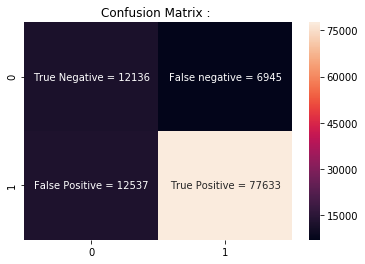

In [41]:
CM(test['Score'],pred)

### Saving the tree to a PDF file.

In [17]:
tmp=tree_viz(std_BOW1_train,train['Score'],BOW1)
tmp.render(filename='G:\ML\Exercises\ex 7\Graphviz\BOW_Bigram')

'G:\\ML\\Exercises\\ex 7\\Graphviz\\BOW_Bigram.pdf'

## Feature Importance:

Top 20 important features are : 



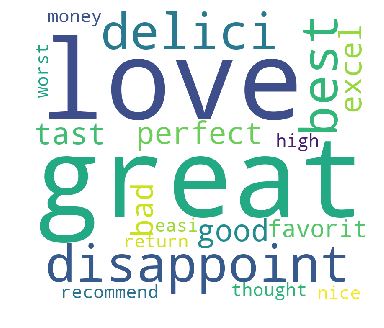

In [81]:
feat_importance(dt,BOW1)

# 3.) TF-IDF Vectorization:

In [19]:
tfidf=TfidfVectorizer(dtype='float')
tfidf.fit(train['New'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='float', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=1, ngram_range=(1, 1),
        norm='l2', preprocessor=None, smooth_idf=True, stop_words=None,
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [20]:
tfidf_train= tfidf.transform(train['New'])
tfidf_test= tfidf.transform(test['New'])

In [17]:
tfidf_train.shape

(254920, 55207)

In [21]:
scaler=StandardScaler(with_mean=False)
std_tfidf_train=scaler.fit_transform(tfidf_train)
std_tfidf_test=scaler.transform(tfidf_test)

### Cross validation :

In [31]:
t_grid=grid_s(std_tfidf_train[:10000])

In [32]:
t_grid.fit(std_tfidf_train[:10000],train['Score'][:10000])

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.0s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=1, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.1s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.1s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.1s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.2s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.1s
[CV] max_depth=1 .....................................................
[CV] .

[CV] ..................................... max_depth=13, total=   0.2s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.4s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.5s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.6s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.8s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.8s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   1.1s
[CV] max_depth=13 ....................................................
[CV] .

[CV] ..................................... max_depth=23, total=   2.1s
[CV] max_depth=23 ....................................................
[CV] ..................................... max_depth=23, total=   2.5s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   0.1s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   0.3s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   0.6s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   0.7s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   1.0s
[CV] max_depth=25 ....................................................
[CV] .

[CV] ..................................... max_depth=35, total=   1.8s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=   2.1s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=   2.5s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=   2.9s
[CV] max_depth=37 ....................................................
[CV] ..................................... max_depth=37, total=   0.1s
[CV] max_depth=37 ....................................................
[CV] ..................................... max_depth=37, total=   0.4s
[CV] max_depth=37 ....................................................
[CV] ..................................... max_depth=37, total=   0.7s
[CV] max_depth=37 ....................................................
[CV] .

[CV] ..................................... max_depth=47, total=   1.4s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   1.8s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   2.1s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   2.7s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   2.6s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   3.1s
[CV] max_depth=49 ....................................................
[CV] ..................................... max_depth=49, total=   0.2s
[CV] max_depth=49 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  5.2min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000021EB2C42150>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': range(1, 50, 2)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [33]:
t_grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=49, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [34]:
t_grid.best_score_

0.7984598459845985

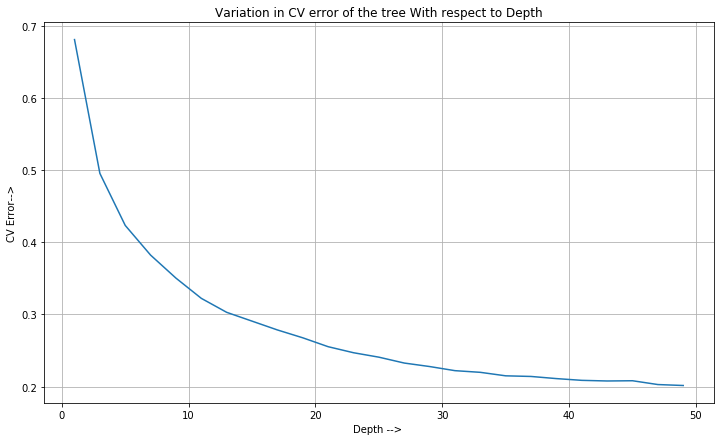

In [35]:
plotter(t_grid)

In [46]:
t_grid=grid_s(std_tfidf_train[:10000],[10,100,150,200,250,300])

In [47]:
t_grid.fit(std_tfidf_train[:10000],train['Score'][:10000])

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.1s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ..................................... max_depth=10, total=   0.2s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.4s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.6s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.7s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.8s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   1.3s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   1.3s
[CV] max_depth=10 ....................................................
[CV] .

[CV] .................................... max_depth=300, total=   6.4s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.7min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000178104ACF68>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [10, 100, 150, 200, 250, 300]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [48]:
t_grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=300, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [49]:
t_grid.best_score_

0.8171617161716171

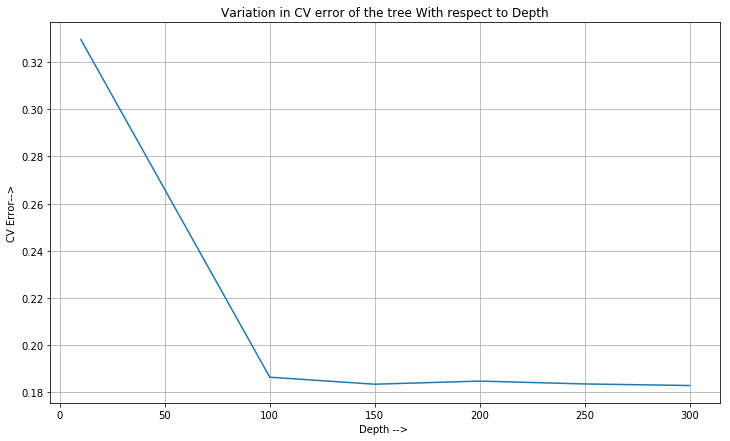

In [50]:
plotter(t_grid)

Similarly even inflection point for Tf-Idf occured at a <b> depth of 100

In [73]:
#Random Search
t_rand=random_s(std_tfidf_train[0:10000])

In [74]:
t_rand.fit(std_tfidf_train[0:10000],train['Score'][0:10000])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] max_depth=94.55760459134024 .....................................
[CV] ...................... max_depth=94.55760459134024, total=   0.4s
[CV] max_depth=94.55760459134024 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ...................... max_depth=94.55760459134024, total=   0.8s
[CV] max_depth=94.55760459134024 .....................................
[CV] ...................... max_depth=94.55760459134024, total=   1.2s
[CV] max_depth=94.55760459134024 .....................................
[CV] ...................... max_depth=94.55760459134024, total=   1.6s
[CV] max_depth=94.55760459134024 .....................................
[CV] ...................... max_depth=94.55760459134024, total=   3.5s
[CV] max_depth=94.55760459134024 .....................................
[CV] ...................... max_depth=94.55760459134024, total=   3.8s
[CV] max_depth=94.55760459134024 .....................................
[CV] ...................... max_depth=94.55760459134024, total=   3.4s
[CV] max_depth=94.55760459134024 .....................................
[CV] ...................... max_depth=94.55760459134024, total=   3.5s
[CV] max_depth=94.55760459134024 .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   28.0s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000142428CCBA0>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [94.55760459134024]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [75]:
t_rand.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=94.55760459134024, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=3, splitter='best')

In [76]:
t_rand.best_score_

0.8123212321232123

### Implementation:

In [87]:
dt1=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')


In [88]:
dt1.fit(std_tfidf_train,train['Score'])

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [98]:
pred=dt1.predict(std_tfidf_test)

In [90]:
acc=accuracy_score(pred,test['Score'])
print(acc*100)

81.4637852285105


## Performace of Decision tree model with TF-IDF:


******************************************************************************* 

 Accuracy is 0.814637852285105

******************************************************************************* 

 TNR value is 0.5996016980242126
 FNR value is 0.4003983019757874
 FPR value is 0.13985804591327491
 TPR value is 0.8601419540867251

******************************************************************************* 

 Confusion Matrix is :
[[11441  7640]
 [12611 77559]]

******************************************************************************* 

 Precision is 0.8601419540867251
 Recall value is 0.9103275860045306
 F1 Score is 0.884523490468669

******************************************************************************* 

Heat Map of the Confusion matrix is

******************************************************************************* 



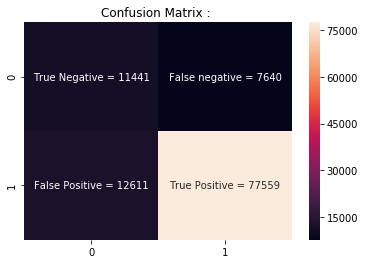

In [99]:
CM(test['Score'],pred)

### Saving the tree to a PDF file.

In [22]:
tmp=tree_viz(std_tfidf_train,train['Score'],tfidf)
tmp.render(filename='G:\ML\Exercises\ex 7\Graphviz\Tf-Idf')

'G:\\ML\\Exercises\\ex 7\\Graphviz\\Tf-Idf.pdf'

## Feature Importance:

Top 20 important features are : 



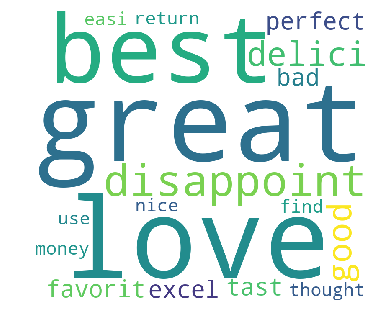

In [91]:
feat_importance(dt1,tfidf)

# Building W2V Model:

In [42]:
from gensim.models import Word2Vec

In [43]:
#Creating sentence list

sentence_list=[]
for sentence in train['New']:
    sentence_list.append(sentence.split())

#sentence_list[5]


In [44]:
w2v=Word2Vec(sentence_list,size=200,min_count=1,workers=4)

In [45]:
w2v_list=list(w2v.wv.vocab)

In [26]:
len(w2v_list)

55208

# 4.) Average W2V Vectorization:

In [29]:
def avgwv(x):
    '''
    To calculate average word 2 vector model
    '''
    sent_vect=[]
    for sentence in x:
        count=0;
        s_v=np.zeros(200)
        for words in sentence.split():
            if words in w2v_list:
                V=w2v.wv[words]
                count+=1
                s_v+=V
            if (count!=0):
                s_v/=count
        sent_vect.append(s_v)
    return(sent_vect)
                    

In [30]:
train_w2v=avgwv(train['New'])

In [31]:
test_w2v=avgwv(test['New'])

In [14]:
import pickle

In [15]:
with open(r'G:\ML\Pickles\Avgw2v_200d.pickle','rb') as f:
    train_w2v,test_w2v=pickle.load(f)

In [16]:
scaler=StandardScaler(with_mean=False)
std_train_avgw2v=scaler.fit_transform(train_w2v)
std_test_avgw2v=scaler.transform(test_w2v)

### Cross Validation :

In [92]:
avg1_grid=grid_s(std_train_avgw2v[:10000])

In [93]:
avg1_grid.fit(std_train_avgw2v[:10000],train['Score'][:10000])

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.0s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=1, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.1s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.2s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.2s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.3s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.4s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.5s
[CV] max_depth=1 .....................................................
[CV] .

[CV] ..................................... max_depth=11, total=   4.2s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.1s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.3s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.7s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.9s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   1.2s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   1.5s
[CV] max_depth=13 ....................................................
[CV] .

[CV] ..................................... max_depth=23, total=   2.8s
[CV] max_depth=23 ....................................................
[CV] ..................................... max_depth=23, total=   3.2s
[CV] max_depth=23 ....................................................
[CV] ..................................... max_depth=23, total=   3.4s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   0.1s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   0.3s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   0.7s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   1.2s
[CV] max_depth=25 ....................................................
[CV] .

[CV] ..................................... max_depth=35, total=   1.8s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=   2.6s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=   2.7s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=   3.1s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=   3.6s
[CV] max_depth=37 ....................................................
[CV] ..................................... max_depth=37, total=   0.2s
[CV] max_depth=37 ....................................................
[CV] ..................................... max_depth=37, total=   0.3s
[CV] max_depth=37 ....................................................
[CV] .

[CV] ..................................... max_depth=47, total=   1.0s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   1.3s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   1.6s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   2.1s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   2.6s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   3.3s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   3.8s
[CV] max_depth=49 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  7.3min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000014246BCF7D8>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': range(1, 50, 2)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [94]:
avg1_grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=29, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [95]:
avg1_grid.best_score_

0.8255225522552255

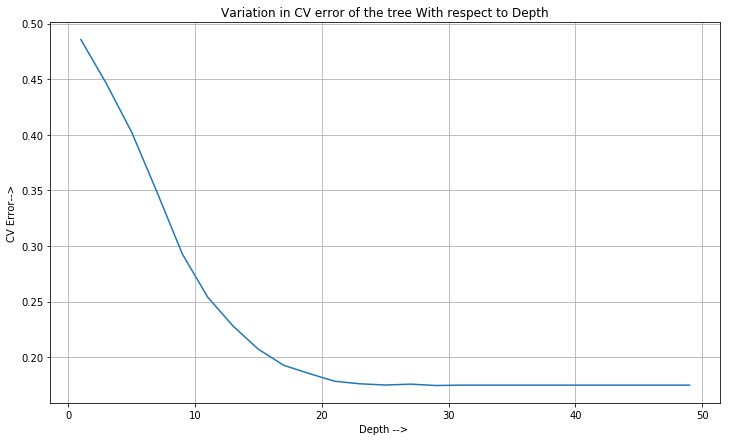

In [96]:
plotter(avg1_grid)

In [54]:
avg1_grid=grid_s(std_train_avgw2v[:10000],[10,100,150,200,250,300])

In [55]:
avg1_grid.fit(std_train_avgw2v[:10000],train['Score'][:10000])

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.1s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ..................................... max_depth=10, total=   0.3s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.7s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   1.1s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   1.7s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   1.8s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   2.2s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   2.6s
[CV] max_depth=10 ....................................................
[CV] .

[CV] .................................... max_depth=300, total=   4.1s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.2min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000178544F0FC0>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [10, 100, 150, 200, 250, 300]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [56]:
avg1_grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [57]:
avg1_grid.best_score_

0.8251925192519252

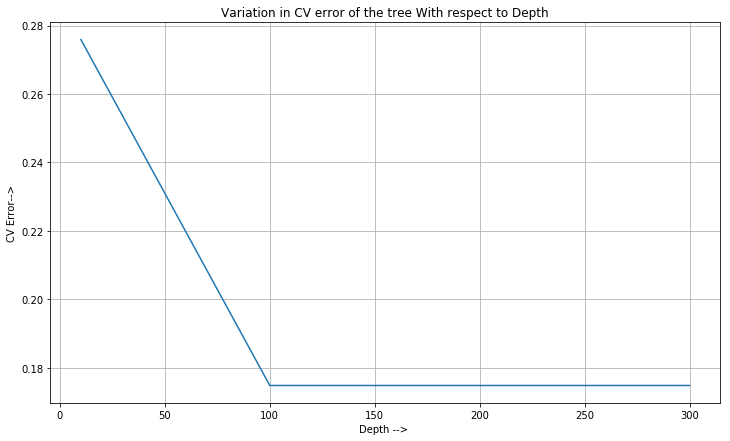

In [58]:
plotter(avg1_grid)

In [97]:
#Random Search
avg1_rand=random_s(std_train_avgw2v[:10000])

In [98]:
avg1_rand.fit(std_train_avgw2v[:10000],train['Score'][:10000])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] max_depth=29.965568806114796 ....................................
[CV] ..................... max_depth=29.965568806114796, total=   0.2s
[CV] max_depth=29.965568806114796 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ..................... max_depth=29.965568806114796, total=   0.4s
[CV] max_depth=29.965568806114796 ....................................
[CV] ..................... max_depth=29.965568806114796, total=   0.9s
[CV] max_depth=29.965568806114796 ....................................
[CV] ..................... max_depth=29.965568806114796, total=   1.3s
[CV] max_depth=29.965568806114796 ....................................
[CV] ..................... max_depth=29.965568806114796, total=   1.8s
[CV] max_depth=29.965568806114796 ....................................
[CV] ..................... max_depth=29.965568806114796, total=   2.6s
[CV] max_depth=29.965568806114796 ....................................
[CV] ..................... max_depth=29.965568806114796, total=   3.3s
[CV] max_depth=29.965568806114796 ....................................
[CV] ..................... max_depth=29.965568806114796, total=   3.3s
[CV] max_depth=29.965568806114796 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000014246BCFAF0>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [29.965568806114796]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [99]:
avg1_rand.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=29.965568806114796, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=3, splitter='best')

In [100]:
avg1_rand.best_score_

0.8255225522552255

### Implementation:

In [49]:
dt=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [50]:
dt.fit(std_train_avgw2v,train['Score'])

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [51]:
pred1=dt.predict(std_test_avgw2v)

In [52]:
acc=accuracy_score(pred1,test['Score'])
print(acc*100)

77.35489835333314


## Performace of Decision tree model with Avg W2V:


******************************************************************************* 

 Accuracy is 0.7735489835333315

******************************************************************************* 

 TNR value is 0.29830721660290344
 FNR value is 0.7016927833970966
 FPR value is 0.12588444050127537
 TPR value is 0.8741155594987247

******************************************************************************* 

 Confusion Matrix is :
[[ 5692 13389]
 [11351 78819]]

******************************************************************************* 

 Precision is 0.8741155594987247
 Recall value is 0.8547956793336804
 F1 Score is 0.8643476735132527

******************************************************************************* 

Heat Map of the Confusion matrix is

******************************************************************************* 



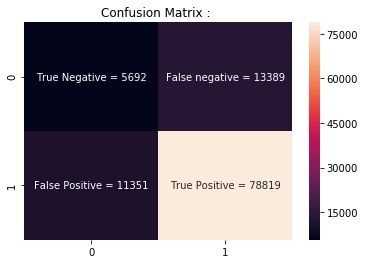

In [53]:
CM(test['Score'],pred1)

### Saving the tree to a PDF file.

In [17]:
d_tree=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')
d_tree.fit(std_train_avgw2v,train['Score'])
DT=tree.export_graphviz(d_tree,out_file=None,class_names=['positive','negative'],filled=True)
x=graphviz.Source(DT)
x.render(filename='G:\ML\Exercises\ex 7\Graphviz\Avg_w2v')

'G:\\ML\\Exercises\\ex 7\\Graphviz\\Avg_w2v.pdf'

#### We can't obtain feature importance from wor2vec models as each dimension there doesn't correspond to a unique word in a dataset like in BOW & Tfidf.

# 5.) Tf-IDF weighted Word2Vec Vectorization:

In [37]:
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [40]:
features=tfidf.get_feature_names()

def tfidf_w2v(x):
    '''
    To calculate Tf-IDf weighted word2vec for a review
    '''     
    row=0
    sentence_vectors=[]
    for sentences in x:
        weight=0
        s_v=np.zeros(200)
        for words in sentences.split():
            if words in w2v_list:
                try:
                    v=w2v.wv[words]
                    #tfidf_value=y[row,features.index(words)]
                    tfidf_value = dictionary[words]*sentences.count(words)
                    s_v+=(v*tfidf_value)
                    weight+=tfidf_value
                except(KeyError):
                    continue                
            else:
                continue
        if(weight!=0):
            s_v/=weight
        sentence_vectors.append(s_v)
        row+=1
    return sentence_vectors
                
    
    

In [18]:
with open(r'G:\ML\Pickles\tfidfw2v_train_200d.pickle','rb') as f:
    train_tfidf_w2v=pickle.load(f)

In [19]:
with open(r'G:\ML\Pickles\tfidfw2v_test_200d.pickle','rb') as f:
    test_tfidf_w2v=pickle.load(f)

In [20]:
scaler=StandardScaler(with_mean=False)
std_train_tfidfw2v=scaler.fit_transform(train_tfidf_w2v)
std_test_tfidfw2v=scaler.transform(test_tfidf_w2v)

### Cross validation:

In [85]:
tfidf_w2v_grid=grid_s(std_train_tfidfw2v[:10000])

In [86]:
tfidf_w2v_grid.fit(std_train_tfidfw2v[:10000],train['Score'][:10000])

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.0s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=1, total=   0.0s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.1s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.1s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.2s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.4s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.4s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=   0.5s
[CV] max_depth=1 .....................................................
[CV] .

[CV] ..................................... max_depth=11, total=   4.2s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.1s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.4s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.7s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   1.2s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   1.8s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   2.1s
[CV] max_depth=13 ....................................................
[CV] .

[CV] ..................................... max_depth=23, total=   3.9s
[CV] max_depth=23 ....................................................
[CV] ..................................... max_depth=23, total=   4.7s
[CV] max_depth=23 ....................................................
[CV] ..................................... max_depth=23, total=   5.9s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   0.1s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   0.6s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   1.0s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=   1.5s
[CV] max_depth=25 ....................................................
[CV] .

[CV] ..................................... max_depth=35, total=   1.9s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=   2.4s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=   3.0s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=   3.6s
[CV] max_depth=35 ....................................................
[CV] ..................................... max_depth=35, total=   4.2s
[CV] max_depth=37 ....................................................
[CV] ..................................... max_depth=37, total=   0.1s
[CV] max_depth=37 ....................................................
[CV] ..................................... max_depth=37, total=   0.4s
[CV] max_depth=37 ....................................................
[CV] .

[CV] ..................................... max_depth=47, total=   1.3s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   1.7s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   2.2s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   3.8s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   4.2s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   4.6s
[CV] max_depth=47 ....................................................
[CV] ..................................... max_depth=47, total=   5.2s
[CV] max_depth=49 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  9.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001423AC1AB48>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': range(1, 50, 2)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [87]:
tfidf_w2v_grid.best_score_

0.8426842684268426

In [88]:
tfidf_w2v_grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=29, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

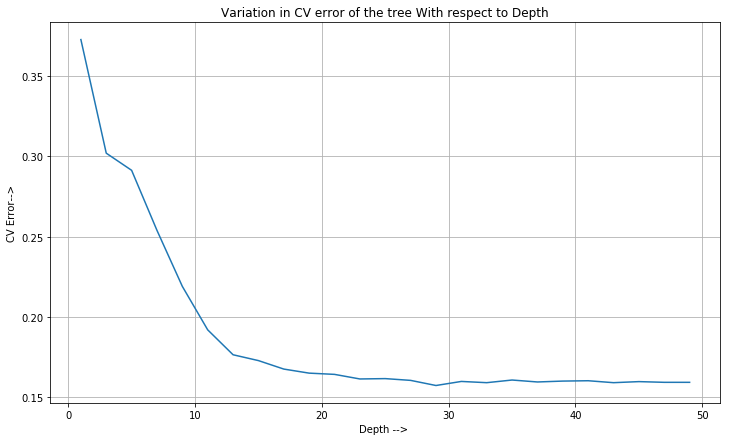

In [89]:
plotter(tfidf_w2v_grid)

In [106]:
tfidf_w2v_grid=grid_s(std_train_tfidfw2v[:10000],[10,100,150,200,250,300])

In [107]:
tfidf_w2v_grid.fit(std_train_tfidfw2v[:10000],train['Score'][:10000])

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.2s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ..................................... max_depth=10, total=   0.5s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   0.7s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   1.1s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   1.4s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   2.1s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   2.4s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=10, total=   2.7s
[CV] max_depth=10 ....................................................
[CV] .

[CV] .................................... max_depth=300, total=   5.6s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.5min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001781B218AF0>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [10, 100, 150, 200, 250, 300]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [108]:
tfidf_w2v_grid.best_score_

0.8407040704070406

In [109]:
tfidf_w2v_grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

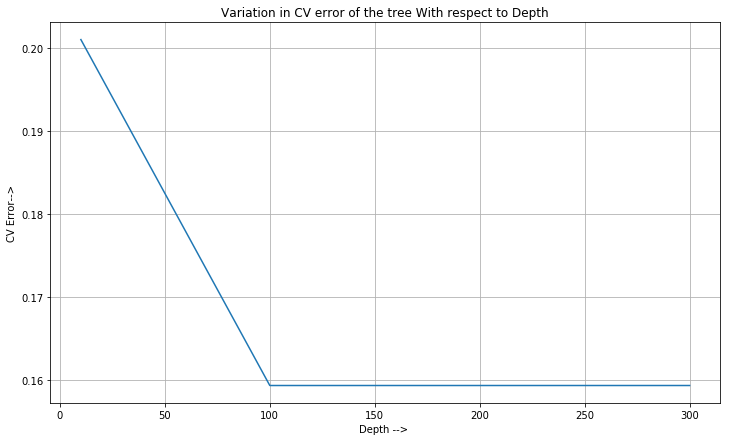

In [110]:
plotter(tfidf_w2v_grid)

In [41]:
#Random Search
tfidf_rand=random_s(std_train_tfidfw2v[:10000])

In [42]:
tfidf_rand.fit(std_train_tfidfw2v[:10000],train['Score'][:10000])

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.6min finished


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000017C3113F570>,
          error_score='raise',
          estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'max_depth': array([259.59158,  46.34836, 877.00142,  18.14752, 783.34871])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=1)

In [43]:
tfidf_rand.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=259.5915842883415, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=3, splitter='best')

In [44]:
tfidf_rand.best_score_

0.8407040704070406

### Implementation:

In [111]:
tfidf_w2v_model=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [112]:
tfidf_w2v_model.fit(std_train_tfidfw2v,train['Score'])

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [113]:
pred2=tfidf_w2v_model.predict(std_test_tfidfw2v)

In [114]:
tfidfw2v_acc=accuracy_score(pred2,test['Score'])

In [115]:
print(tfidfw2v_acc*100)

74.69130717338972


## Performance of Decision tree model with Tf-Idf W2V:


******************************************************************************* 

 Accuracy is 0.7469130717338972

******************************************************************************* 

 TNR value is 0.12934332582149782
 FNR value is 0.8706566741785021
 FPR value is 0.12240212931130087
 TPR value is 0.8775978706886991

******************************************************************************* 

 Confusion Matrix is :
[[ 2468 16613]
 [11037 79133]]

******************************************************************************* 

 Precision is 0.8775978706886991
 Recall value is 0.8264888350427172
 F1 Score is 0.8512769207599131

******************************************************************************* 

Heat Map of the Confusion matrix is

******************************************************************************* 



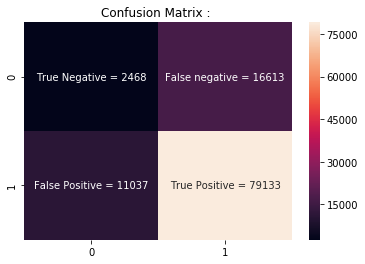

In [116]:
CM(test['Score'],pred2)

### Saving the tree to a PDF file.

In [21]:
d_tree=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')
d_tree.fit(std_train_avgw2v,train['Score'])
DT=tree.export_graphviz(d_tree,out_file=None,class_names=['positive','negative'])
x=graphviz.Source(DT)
x.render(filename='G:\ML\Exercises\ex 7\Graphviz\Tf_idf_w2v')

'G:\\ML\\Exercises\\ex 7\\Graphviz\\Tf_idf_w2v.pdf'

# Sample Visualization of a decision tree:

As mentioned earlier, The below one is the graphical representation of the decision tree with depth of 5, built on input data vectorized in form of Tf-IDF. 

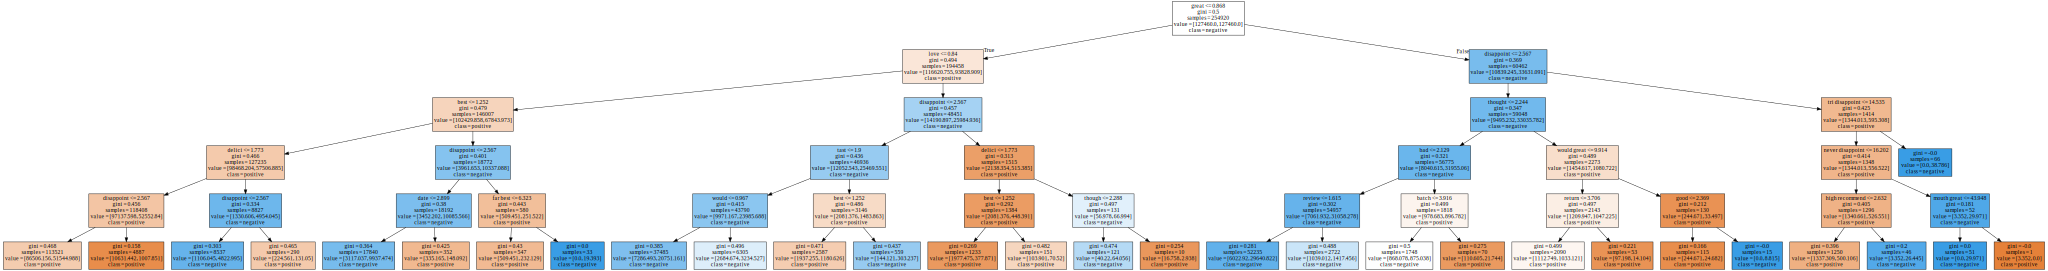

In [18]:
tmp

# Performace comparision between different vectorizations::

In [45]:
tmp=pd.DataFrame(columns=['Type of Vectorization','No. of Dimensions','Optimal_depth','Accuracy','F1 Score'])
tmp.loc[0]=['BOW_Unigram',55207,100,81.88,0.8871]
tmp.loc[1]=['BOW_bigram',2184164,100,82.16,0.8885]
tmp.loc[2]=['Tf-IDF',55207,100,81.46,0.8845]
tmp.loc[3]=['Avg_W2v',200,100,77.35,0.8643]
tmp.loc[4]=['Tf-IDF_W2v',200,100,74.69,0.8412]

In [46]:
tmp

,Type of Vectorization,No. of Dimensions,Optimal_depth,Accuracy,F1 Score
0,BOW_Unigram,55207,100,81.88,0.8871
1,BOW_bigram,2184164,100,82.16,0.8885
2,Tf-IDF,55207,100,81.46,0.8845
3,Avg_W2v,200,100,77.35,0.8643
4,Tf-IDF_W2v,200,100,74.69,0.8412


# Conclusion from above exercise:

1.) The accuracy & F1 Score is high in BOW_bigram, secondly followed by BOW_unigram.

2.) The optimal depth obtained for all types of Vectorization is around 100.

3.) The overall performance of DT is not that good with the given data as it is very high dimensional.


*****************************************************************************************************************************

#### From above exercise I suggest that "BOW_Bigram " can be used with depth as 100 as it is highest on F1 score comparision with others. But each data point will be represented in very high dimension i.e close to 5 times more than BOW & Tf-IDF.
